In [42]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import MaxPool1D, LSTM, Bidirectional, ConvLSTM1D, Conv1D, MaxPool1D
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import seaborn as sns
import math

In [43]:
data = pd.read_csv('data/processed/body_combined.csv')
data.head()

,label,x_acc,y_acc,z_acc,x_gyr,y_gyr,z_gyr
0,Falling,-0.593280,-0.295724,-0.674764,-749.046297,599.261452,1044.343394
1,Falling,-0.578631,-0.299387,-0.672933,-747.215186,592.669454,1044.465468
2,Falling,-0.573138,-0.297555,-0.663778,-745.628223,586.443678,1044.343394
3,Falling,-0.567644,-0.293893,-0.661031,-744.285409,578.753014,1044.465468
4,Falling,-0.554827,-0.299387,-0.657369,-743.064669,571.306497,1044.831690


In [44]:
data.shape

(191004, 7)

In [45]:
data['mag_acc'] = np.sqrt(data['x_acc']*data['x_acc'] + data['y_acc']*data['y_acc'] + data['z_acc']*data['z_acc'])

In [46]:
data

,label,x_acc,y_acc,z_acc,x_gyr,y_gyr,z_gyr,mag_acc
0,Falling,-0.593280,-0.295724,-0.674764,-749.046297,599.261452,1044.343394,0.945907
1,Falling,-0.578631,-0.299387,-0.672933,-747.215186,592.669454,1044.465468,0.936635
2,Falling,-0.573138,-0.297555,-0.663778,-745.628223,586.443678,1044.343394,0.926081
3,Falling,-0.567644,-0.293893,-0.661031,-744.285409,578.753014,1044.465468,0.919541
4,Falling,-0.554827,-0.299387,-0.657369,-743.064669,571.306497,1044.831690,0.910823
...,...,...,...,...,...,...,...,...
190999,Walking,-1.460311,-0.070498,0.931120,36.500137,7.568590,-7.324442,1.733338
191000,Walking,-1.416364,-0.109867,0.866115,35.157323,18.311106,0.732444,1.663825
191001,Walking,-1.424604,-0.180364,0.869778,33.814509,26.612140,0.976592,1.678851
191002,Walking,-1.463973,-0.236213,0.888089,28.931547,33.814509,-2.929777,1.728501


In [47]:
# check for null data
data.isnull().sum()

label      0
x_acc      0
y_acc      0
z_acc      0
x_gyr      0
y_gyr      0
z_gyr      0
mag_acc    0
dtype: int64

In [48]:
# count the datapoints of different activity
data['label'].value_counts()

Walking    91674
Stairs     44352
Running    29964
Sitting    15774
Falling     9240
Name: label, dtype: int64

### Balance this data 

In [49]:
# convert attributes to floats
data['x_acc'] = data['x_acc'].astype('float')
data['y_acc'] = data['y_acc'].astype('float')
data['z_acc'] = data['z_acc'].astype('float')
data['x_gyr'] = data['x_gyr'].astype('float')
data['y_gyr'] = data['y_gyr'].astype('float')
data['z_gyr'] = data['z_gyr'].astype('float')
data['mag_acc'] = data['mag_acc'].astype('float')

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191004 entries, 0 to 191003
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   label    191004 non-null  object 
 1   x_acc    191004 non-null  float64
 2   y_acc    191004 non-null  float64
 3   z_acc    191004 non-null  float64
 4   x_gyr    191004 non-null  float64
 5   y_gyr    191004 non-null  float64
 6   z_gyr    191004 non-null  float64
 7   mag_acc  191004 non-null  float64
dtypes: float64(7), object(1)
memory usage: 11.7+ MB


In [51]:
# frame size, Frames per second
Fs = 33

In [52]:
activities = data['label'].value_counts().index

In [53]:
activities

Index(['Walking', 'Stairs', 'Running', 'Sitting', 'Falling'], dtype='object')

In [54]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=6, figsize=(15, 7), sharex=True)
    x_ticks = np.arange(len(data))
    plot_axis(ax0, x_ticks, data['x_acc'], 'X-Axis acc')
    plot_axis(ax1, x_ticks, data['y_acc'], 'Y-Axis acc')
    plot_axis(ax2, x_ticks, data['z_acc'], 'Z-Axis acc')
    plot_axis(ax3, x_ticks, data['x_gyr'], 'X-Axis gyro')
    plot_axis(ax4, x_ticks, data['y_gyr'], 'Y-Axis gyro')
    plot_axis(ax5, x_ticks, data['z_gyr'], 'Z-Axis gyro')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

# for activity in activities:
#     data_for_plot = data[(data['label'] == activity)][Fs*5:Fs*10]
#     plot_activity(activity, data_for_plot)

In [55]:
counts = data['label'].value_counts()
counts

Walking    91674
Stairs     44352
Running    29964
Sitting    15774
Falling     9240
Name: label, dtype: int64

In [56]:
# calculate weights to balance weights on imbalance classes
# references: https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
# references: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
n_classes = 5
n_total = data.shape[0]

weight_0 = n_total / (n_classes * counts[0]) # 
weight_1 = n_total / (n_classes * counts[1]) #
weight_2 = n_total / (n_classes * counts[2])
weight_3 = n_total / (n_classes * counts[3])
weight_4 = n_total / (n_classes * counts[4])

class_weight = {0: weight_0, 1: weight_1, 2:weight_2, 3: weight_3, 4: weight_4}

In [57]:
class_weight

{0: 0.416702663786897,
 1: 0.8613095238095239,
 2: 1.2748898678414098,
 3: 2.4217573221757323,
 4: 4.134285714285714}

In [58]:
np.unique(data['label'])

array(['Falling', 'Running', 'Sitting', 'Stairs', 'Walking'], dtype=object)

In [59]:
data['label'].value_counts()

Walking    91674
Stairs     44352
Running    29964
Sitting    15774
Falling     9240
Name: label, dtype: int64

In [60]:
data.head()

,label,x_acc,y_acc,z_acc,x_gyr,y_gyr,z_gyr,mag_acc
0,Falling,-0.593280,-0.295724,-0.674764,-749.046297,599.261452,1044.343394,0.945907
1,Falling,-0.578631,-0.299387,-0.672933,-747.215186,592.669454,1044.465468,0.936635
2,Falling,-0.573138,-0.297555,-0.663778,-745.628223,586.443678,1044.343394,0.926081
3,Falling,-0.567644,-0.293893,-0.661031,-744.285409,578.753014,1044.465468,0.919541
4,Falling,-0.554827,-0.299387,-0.657369,-743.064669,571.306497,1044.831690,0.910823


In [61]:
label = LabelEncoder()
data['label_id'] = label.fit_transform(data['label'])
data.tail()

,label,x_acc,y_acc,z_acc,x_gyr,y_gyr,z_gyr,mag_acc,label_id
190999,Walking,-1.460311,-0.070498,0.931120,36.500137,7.568590,-7.324442,1.733338,4
191000,Walking,-1.416364,-0.109867,0.866115,35.157323,18.311106,0.732444,1.663825,4
191001,Walking,-1.424604,-0.180364,0.869778,33.814509,26.612140,0.976592,1.678851,4
191002,Walking,-1.463973,-0.236213,0.888089,28.931547,33.814509,-2.929777,1.728501,4
191003,Walking,-1.519822,-0.267342,0.882595,28.443251,36.866359,-10.620441,1.777725,4


In [62]:
label.classes_

array(['Falling', 'Running', 'Sitting', 'Stairs', 'Walking'], dtype=object)

### Standardized data 

In [85]:
X = data[['x_acc', 'y_acc', 'z_acc', 'x_gyr', 'y_gyr', 'z_gyr', 'mag_acc']]
y = data['label_id']

In [86]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x_acc', 'y_acc', 'z_acc', 'x_gyr', 'y_gyr', 'z_gyr', 'mag_acc'])
scaled_X['label_id'] = y.values

scaled_X

,x_acc,y_acc,z_acc,x_gyr,y_gyr,z_gyr,mag_acc,label_id
0,1.090977,-0.696242,-1.595668,-1.958188,1.652865,2.043967,-1.124222,0
1,1.109405,-0.708374,-1.593219,-1.952304,1.629190,2.044261,-1.136805,0
2,1.116316,-0.702308,-1.580974,-1.947204,1.606830,2.043967,-1.151127,0
3,1.123226,-0.690177,-1.577301,-1.942889,1.579209,2.044261,-1.160004,0
4,1.139351,-0.708374,-1.572403,-1.938966,1.552464,2.045142,-1.171834,0
...,...,...,...,...,...,...,...,...
190999,0.000258,0.049831,0.552099,0.566183,-0.472217,-0.487024,-0.055604,4
191000,0.055543,-0.080580,0.465160,0.561868,-0.433635,-0.467634,-0.149940,4
191001,0.045177,-0.314107,0.470058,0.557553,-0.403822,-0.467046,-0.129548,4
191002,-0.004349,-0.499109,0.494548,0.541861,-0.377954,-0.476448,-0.062169,4


### Frame Preparation 

In [87]:
import scipy.stats as stats

In [88]:
Fs = 33
frame_size = Fs*2
hop_size = Fs*2

In [89]:
scaled_X.shape

(191004, 8)

In [124]:
def get_frames(df, frame_size, hop_size):
    N_FEATURES = 1
    frames = []
    labels = []
    for i in range(0, len(df), hop_size):
        x_acc = df['x_acc'].values[i: i + frame_size]
        y_acc = df['y_acc'].values[i: i + frame_size]
        z_acc = df['z_acc'].values[i: i + frame_size]
        x_gyr = df['x_gyr'].values[i: i + frame_size]
        y_gyr = df['y_gyr'].values[i: i + frame_size]
        z_gyr = df['z_gyr'].values[i: i + frame_size]
        mag_acc = df['mag_acc'].values[i: i + frame_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label_id'][i: i + frame_size])[0][0]
        
        # x_acc, y_acc, z_acc, x_gyr, y_gyr, z_gyr, mag_acc
        frames.append([mag_acc])
        labels.append(label)

    # Bring the segments into a shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [125]:
X, y = get_frames(scaled_X, frame_size, hop_size)

/tmp/ipykernel_116778/467030957.py:15: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df['label_id'][i: i + frame_size])[0][0]


In [126]:
X.shape,y.shape

((2894, 66, 1), (2894,))

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 321, stratify = y)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 7, stratify = y_train)

In [128]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2315, 66, 1)
(2315,)
(579, 66, 1)
(579,)


### CNN 1D

In [73]:
def cnn_1d_model():
    model = Sequential()
    model.add(Conv1D(32, 3, activation = 'relu', input_shape = X_train[0].shape))
    model.add(Dropout(0.2))
    model.add(Conv1D(16, 5, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    return model

### ConvLSTM1D

In [74]:
def ConvLSTM_1D_model():
    model = Sequential()
    model.add(ConvLSTM1D(filters=64, kernel_size=1,
                       input_shape= (X_train[0].shape[0], X_train[0].shape[1],1), return_sequences=True))

    # model.add(ConvLSTM1D(filters=32, kernel_size=3))
    
    model.add(Flatten())
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(5, activation='softmax'))
    return model

In [75]:
ConvLSTM_1D_model()

### LSTM

In [76]:
def lstm_model():
    # X_train = X_train.reshape(X_train.shape[0], 66, X_test.shape[2])
    # X_val = X_val.reshape(X_val.shape[0], 66, X_test.shape[2])
    # X_test = X_test.reshape(X_test.shape[0], 66, X_test.shape[2])

    model = Sequential()
    model.add(LSTM(units=256, input_shape= X_train[0].shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(5, activation='softmax'))
    return model
    

### Bi-LSTM

In [77]:
def bilstm_model():
    # X_train = X_train.reshape(X_train.shape[0], 66, X_test.shape[2])
    # X_val = X_val.reshape(X_val.shape[0], 66, X_test.shape[2])
    # X_test = X_test.reshape(X_test.shape[0], 66, X_test.shape[2])

    model = Sequential()
    model.add(Bidirectional(LSTM(units=256, input_shape= X_train[0].shape, return_sequences=True)))
    model.add(Dropout(0.4))
    model.add(Bidirectional(LSTM(units=256, input_shape= X_train[0].shape, return_sequences=True)))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(5, activation='softmax'))
    return model

### CNN-LSTM

In [108]:
def cnn_lstm_model():
    # X_train = X_train.reshape(X_train.shape[0], 66, X_test.shape[2])
    # X_val = X_val.reshape(X_val.shape[0], 66, X_test.shape[2])
    # X_test = X_test.reshape(X_test.shape[0], 66, X_test.shape[2])

    model = Sequential()
    model.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(X_train[0].shape)))
    model.add(MaxPool1D(pool_size=2))
    model.add(Dropout(0.1))
    model.add(LSTM(units=256))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(5, activation='softmax'))
    return model

In [99]:
def calculate_class_weights(y):
    import sklearn
    class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight = "balanced",
                                                    classes = np.unique(y),
                                                    y = y)
    class_weights = dict(zip(np.unique(y), class_weights))
    
    return class_weights

In [107]:
X_val_fold.shape

(232, 66, 6)

### 10-Fold Cross Validation

In [129]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10)

for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # define model
    model = cnn_lstm_model()
        
    # compile model
    model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])    
        
    # reshape data if needed
    flag = '1D' #1D or 2D
    
    if flag == '1D':
        X_train_fold = X_train_fold.reshape(X_train_fold.shape[0], X_train_fold[0].shape[0], X_train_fold[0].shape[1])
        X_val_fold = X_val_fold.reshape(X_val_fold.shape[0], 66, X_val_fold.shape[2])
        X_test = X_test.reshape(X_test.shape[0], 66, X_test.shape[2])
    elif flag == '2D':
        X_train_fold = X_train_fold.reshape(X_train_fold.shape[0], X_train_fold[0].shape[0], X_train_fold[0].shape[1],1)
        X_val_fold = X_val_fold.reshape(X_val_fold.shape[0], X_val_fold[0].shape[0], X_val_fold[0].shape[1],1)
        X_test = X_test.reshape(X_test.shape[0], X_test[0].shape[0], X_test[0].shape[1],1)
        
    # calculate class_weight
    class_weights = calculate_class_weights(y_train_fold)
    
    # early stopping
    es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=9)
    
    # train model
    history = model.fit(X_train_fold, y_train_fold, epochs = 100, validation_data= (X_val_fold, y_val_fold), verbose=0, callbacks = [es], class_weight = class_weights)

    # convert the history.history dict to a pandas DataFrame:     
    # history_df = pd.DataFrame(history.history) 
    
    # evaluate
    y_pred = np.argmax(model.predict(X_val_fold, verbose=0), axis=-1)
    mat = confusion_matrix(y_val_fold, y_pred)
    
    # plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))
    print(accuracy_score(y_val_fold, y_pred))


0.9137931034482759
0.9051724137931034
0.8793103448275862
0.896551724137931
0.8577586206896551
0.922077922077922
0.9437229437229437
0.8744588744588745
0.922077922077922
0.9177489177489178


## After comparing cross validation results for different models, we found that LSTM model trained on 6 features was performing slightly better than other methods. So, After here, we use this configuration for all dataset

In [81]:
# calculate class_weight
class_weights = calculate_class_weights(y_train)

# define model
model = lstm_model()

# early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)
          
# compile model
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])    

# train model
history = model.fit(X_train, y_train, validation_split=0.1, epochs = 100, verbose=1, callbacks = [es], class_weight = class_weights)

Epoch 1/100
66/66 [==============================] - 16s 195ms/step - loss: 1.5545 - accuracy: 0.2324 - val_loss: 1.6884 - val_accuracy: 0.0776
Epoch 2/100
66/66 [==============================] - 12s 186ms/step - loss: 1.5109 - accuracy: 0.2376 - val_loss: 1.5215 - val_accuracy: 0.2112
Epoch 3/100
66/66 [==============================] - 12s 185ms/step - loss: 1.4473 - accuracy: 0.2847 - val_loss: 1.6835 - val_accuracy: 0.1681
Epoch 4/100
66/66 [==============================] - 12s 185ms/step - loss: 1.4805 - accuracy: 0.2573 - val_loss: 1.4241 - val_accuracy: 0.3190
Epoch 5/100
66/66 [==============================] - 12s 186ms/step - loss: 1.4180 - accuracy: 0.3303 - val_loss: 1.6782 - val_accuracy: 0.1767
Epoch 6/100
66/66 [==============================] - 13s 191ms/step - loss: 1.3877 - accuracy: 0.3581 - val_loss: 1.2367 - val_accuracy: 0.4267
Epoch 7/100
66/66 [==============================] - 13s 191ms/step - loss: 1.2294 - accuracy: 0.4551 - val_loss: 1.3571 - val_accuracy:

19/19 [==============================] - 2s 76ms/step


0.47668393782383417

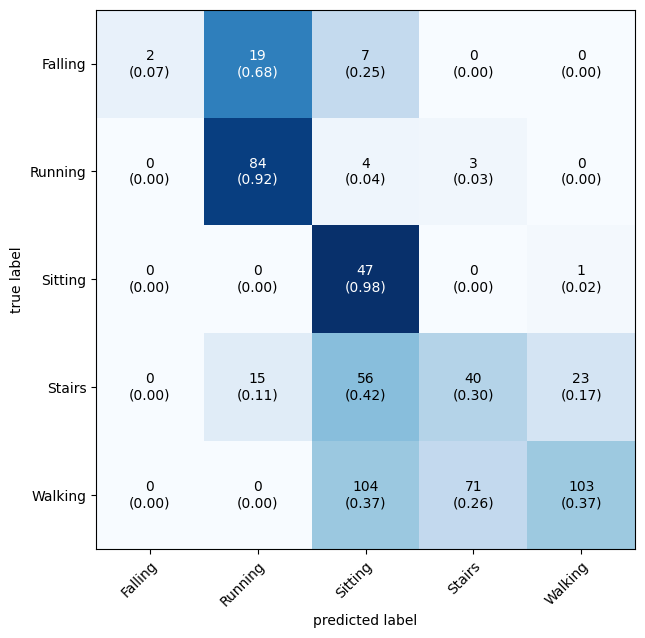

In [82]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))

accuracy_score(y_test, y_pred)

### Confusion Matrix 

0.9163071613459879

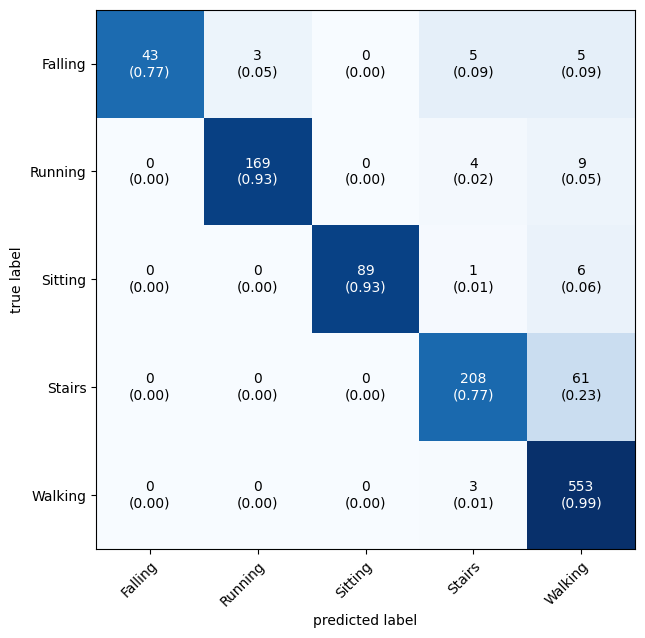

In [119]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))

accuracy_score(y_test, y_pred)

In [59]:
model.save('models/cnn1D_6_young_body.h5')

In [110]:
y_predqq = np.argmax(model.predict(X_test), axis=-1)
accuracy_score(y_test, y_predqq)

37/37 [==============================] - 0s 2ms/step


0.9361518550474547

In [176]:
model_pretrained = load_model('models/WB_young_body_LSTM_6.h5')

In [171]:
# Freeze the layers
for layer in model_pretrained.layers[:]:
    layer.trainable = False

for layer in model_pretrained.layers[2:]:
    layer.trainable = True


In [172]:
for layer in model_pretrained.layers[:]:
    print(layer, layer.trainable)

<keras.layers.rnn.lstm.LSTM object at 0x7fdd61c63670> False
<keras.layers.regularization.dropout.Dropout object at 0x7fdc9ce16f50> False
<keras.layers.rnn.lstm.LSTM object at 0x7fdd615af100> True
<keras.layers.reshaping.flatten.Flatten object at 0x7fdd63f11c90> True
<keras.layers.core.dense.Dense object at 0x7fdc265634f0> True
<keras.layers.regularization.dropout.Dropout object at 0x7fdc9ee57d30> True
<keras.layers.core.dense.Dense object at 0x7fdd61c61180> True


In [177]:
model_pretrained.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model_pretrained.fit(X_train, y_train, epochs = 100, validation_data= (X_val, y_val), verbose=1, callbacks = [es])

In [178]:
y_pred = np.argmax(model_pretrained.predict(X_test), axis=-1)

37/37 [==============================] - 4s 85ms/step


0.9628990509059534

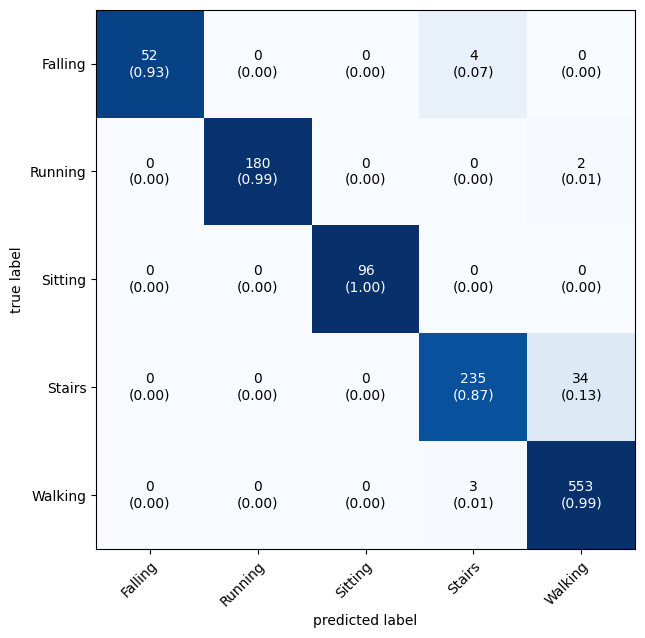

In [179]:
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))

accuracy_score(y_test, y_pred)

In [180]:
model_pretrained.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 66, 256)           269312    
                                                                 
 dropout_22 (Dropout)        (None, 66, 256)           0         
                                                                 
 lstm_5 (LSTM)               (None, 66, 256)           525312    
                                                                 
 flatten_8 (Flatten)         (None, 16896)             0         
                                                                 
 dense_16 (Dense)            (None, 64)                1081408   
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 5)                

### Multiclass TSNE Plot LSTM

37/37 [==============================] - 4s 86ms/step


/home/suresh/anaconda3/envs/activity/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


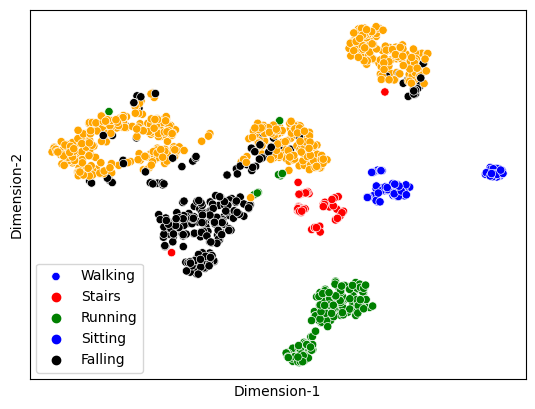

In [208]:

# create truncated model
truncated_model_pretrained = Model(inputs=model_pretrained.input,
                                 outputs=model_pretrained.get_layer(index=5).output)

hidden_features = truncated_model_pretrained.predict(X_test)

df = pd.DataFrame()
df['Target'] = y_test

m = TSNE(learning_rate = 10, perplexity=40)
tsne_features = m.fit_transform(hidden_features)
df['Dimension-1'] = tsne_features[:,0]
df['Dimension-2'] = tsne_features[:,1]

sns.scatterplot(x="Dimension-1",y="Dimension-2",hue='Target',data=df, palette=['red','green','blue','black','orange'])
plt.tick_params(top=False,
               bottom=False,
               left=False,
               right=False,
               labelleft=False,
               labelbottom=False)

# plt.axis('off')
# plt.set_xlabel('Subplot 1')
plt.legend(loc = 0, labels=['Walking', 'Stairs', 'Running', 'Sitting', 'Falling']).set_visible(True)
filename = "TSNE_ANN_protT5.png"
plt.savefig(filename,dpi=1600,bbox_inches='tight')
plt.show()

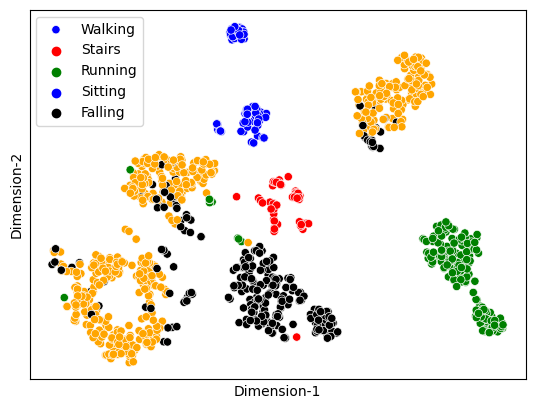

### Multiclass TSNE Plot features only

In [219]:
temp = []
for i in X_test:
    temp.append(i[0])

In [220]:
temp = np.array(temp)

In [221]:
temp.shape

(1159, 6)

In [225]:
# create truncated model
hidden_features_1 = temp

df = pd.DataFrame()
df['Target'] = y_test

m = TSNE(learning_rate = 20, perplexity=60)
tsne_features = m.fit_transform(hidden_features_1)
df['Dimension-1'] = tsne_features[:,0]
df['Dimension-2'] = tsne_features[:,1]

/home/suresh/anaconda3/envs/activity/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


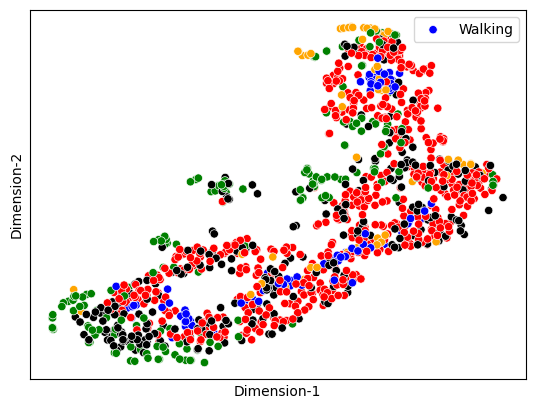

In [243]:

sns.scatterplot(x="Dimension-1", y="Dimension-2", hue='Target', data=df, palette=['orange','green','blue','black','red'], legend=False)
plt.tick_params(top=False,
               bottom=False,
               left=False,
               right=False,
               labelleft=False,
               labelbottom=False)

# plt.axis('off')
# plt.set_xlabel('Subplot 1')
plt.legend(labels=['Walking', 'Stairs', 'Running', 'Sitting', 'Falling'])
filename = "1.png"
plt.savefig(filename,dpi=1600,bbox_inches='tight')
plt.show()